In [1]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 74.3 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import os, glob, pickle
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import soundfile
seed=7
np.random.seed(seed)

2024-07-23 03:37:12.890920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 03:37:12.891057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 03:37:13.053252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# CREATE DIRECTORY OF AUDIO FILES 
CaFE = "/kaggle/input/cafe-speech-emotion-recognition-db/"
dir_list = os.listdir(CaFE) #list files in audio directory
dir_list.remove('License.txt')
dir_list.remove('Readme.txt')
dir_list

['Surprise', 'Degout', 'Joie', 'Tristesse', 'Peur', 'Neutre', 'Colere']

In [5]:
emotion_map = {
    "C": "Anger",
    "D": "Disgust",
    "J": "Happiness",
    "N": "Neutral",
    "P": "Fear",
    "S": "Surprise",
    "T": "Sadness"
}

# Initialize a list to store rows of the DataFrame
data = []

# Loop through each directory and each file within the directory
for directory in dir_list:
    dir_path = os.path.join(CaFE, directory)
    sub_dir = os.listdir(dir_path)
    for dir in sub_dir:
        directory_path = os.path.join(dir_path, dir)
        if os.path.isdir(directory_path):
            for filename in os.listdir(directory_path):
                # print(filename)
                # Extract the emotion abbreviation from the filename
                emo_abb = filename.split('-')[1]
                # print(emo_abb)
                # Get the emotion name from the emotion_map dictionary
                emotion = emotion_map.get(emo_abb, 'Unknown')
                # Full path to the audio file
                file_path = os.path.join(directory_path, filename)
                # Append the emotion and file path to the data list
                data.append([emotion, file_path])

    #         break
    # break

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['Emotions', 'path'])

In [6]:
# EMO_df.head(5)
data_path = df
data_path.head(5)
# data.shape

,Emotions,path
0,Surprise,/kaggle/input/cafe-speech-emotion-recognition-...
1,Surprise,/kaggle/input/cafe-speech-emotion-recognition-...
2,Surprise,/kaggle/input/cafe-speech-emotion-recognition-...
3,Surprise,/kaggle/input/cafe-speech-emotion-recognition-...
4,Surprise,/kaggle/input/cafe-speech-emotion-recognition-...


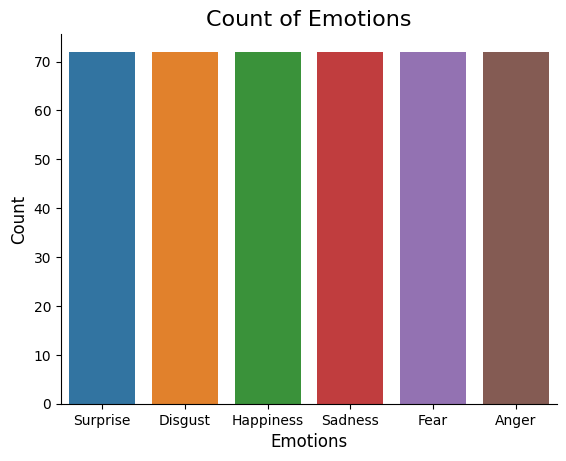

In [7]:
from sklearn.preprocessing import LabelEncoder

# Assuming data_path is a DataFrame with an 'emotion' column (containing text labels)

# Create a label encoder
le = LabelEncoder()

# Encode the emotion labels
data_path['emotion_encoded'] = le.fit_transform(data_path['Emotions'])

# Create the countplot using the encoded emotion column
plt.title('Count of Emotions', size=16)
sns.countplot(x="Emotions", data=data_path)  # Use "x" for the category variable
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove top and right spines, keep bottom and left for reference
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def noise2(data):
    noise_amp = 0.025*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

def pitch2(data, sampling_rate, pitch_factor=0.6):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)
# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [10]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
       
    return result

In [11]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with noise2
    noise_data2 = noise2(data)
    res3 = extract_features(noise_data2)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with stretching and pitching
    new_data1 = stretch(data)
    data_stretch_pitch = pitch2(new_data1, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically
    return result

In [14]:
X, Y = [], []
for path, emotion in zip(df.path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [15]:
len(X), len(Y), data_path.path.shape

(2160, 2160, (432,))

In [16]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,labels
0,0.173023,0.653598,0.627806,0.635756,0.604729,0.556872,0.605717,0.672419,0.639981,0.621263,...,0.001393,0.001753,0.003101,0.003374,0.003912,0.003503,0.004080,0.002213,0.000135,Surprise
1,0.360903,0.722475,0.713323,0.726835,0.737816,0.728488,0.642049,0.642163,0.665286,0.641681,...,0.001455,0.001849,0.003217,0.003477,0.003986,0.003563,0.004191,0.002304,0.000217,Surprise
2,0.362495,0.718597,0.711375,0.725492,0.743033,0.735998,0.657394,0.652102,0.666824,0.638121,...,0.001530,0.001959,0.003274,0.003550,0.004079,0.003721,0.004312,0.002444,0.000324,Surprise
3,0.182075,0.670815,0.648134,0.609777,0.632747,0.547725,0.496206,0.590677,0.673653,0.646697,...,0.000448,0.000323,0.000353,0.000492,0.000543,0.000831,0.000612,0.000337,0.000040,Surprise
4,0.181966,0.686211,0.632797,0.611732,0.580153,0.515053,0.564503,0.649634,0.661803,0.615349,...,0.000445,0.000360,0.000377,0.000668,0.000807,0.000904,0.000633,0.000399,0.000031,Surprise


In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1728, 155), (1728,), (432, 155), (432,))

In [18]:
# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

In [19]:
# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [20]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
(1728, 155, 1)
(432, 155, 1)


In [21]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=4, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(2160, 6)

In [22]:
import random
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('/kaggle/input/english-mode-e800/saved_models/model1-ravdess.weights.h5') 
model2 = load_model('/kaggle/input/english-mode-e800/saved_models/model2-ravdess.weights.h5')
model3 = load_model('/kaggle/input/english-mode-e800/saved_models/model3-ravdess.weights.h5')

models = [model1, model2, model3]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = np.argmax(model1.predict(x_test), axis=1)
prediction2 = np.argmax(model2.predict(x_test), axis=1)
prediction3 = np.argmax(model3.predict(x_test), axis=1)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), prediction3)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = pd.concat([df, pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0])], ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])         




###########################################################################
### Explore metrics for the ideal weighted ensemble model. 

models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy Score for model1 =  0.18287037037037038
Accuracy Score for model2 =  0.1712962962962963
Accuracy Score for model3 =  0.1597222222222222
Accuracy Score for average ensemble =  0.18287037037037038
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Weighted average method
Accuracy Score for model1 =  0.18287037037037038
Accuracy Score for model2 =  0.1712962962962963
Accuracy Score for model3 =  0.1597222222222222
Accuracy Score for average ensemble =  0.18287037037037038
Accuracy Score for weighted average ensemble =  0.1736111111111111
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Max accuracy of  19

ValueError: Shape of passed values is (8, 8), indices imply (6, 6)